In [ ]:
%matplotlib inline

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torchvision
import torchvision.transforms as transforms

plt.ion()   # interactive mode

In [ ]:
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
#!unzip hymenoptera_data.zip
#!mkdir data && mv hymenoptera_data data/

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = "/content/drive/MyDrive/yoga_pose"
train_path = path + '/Train'
test_path = path + '/Test'

In [ ]:
import splitfolders
splitfolders.ratio(train_path, output="output", seed=42, ratio=(.8, 0.2) )

Copying files: 1466 files [06:38,  3.68 files/s]


In [ ]:
yoga_category = []
images_count = []
train_yoga_category = []
train_data = []
val_yoga_category = []
val_data = []
test_yoga_category = []
test_data = []

splitted_dir ='/content/output/'
#print("Train Data Count")

for pose in os.listdir(splitted_dir + 'train'):
    #print( pose + " images : " + str(len(os.listdir(splitted_dir+'train' + '/'+pose))))
    train_yoga_category.append(pose)
    train_data.append(len(os.listdir(splitted_dir + 'train' + '/'+pose)))    
print("Total Number of Training Images : " + str(np.sum(train_data)))



#print("Validation Data Count")

for pose in os.listdir(splitted_dir + 'train'):
   # print(pose + " images : " + str(len(os.listdir(splitted_dir+'val' + '/'+pose))))
    val_yoga_category.append(pose)
    val_data.append(len(os.listdir(splitted_dir + 'val' + '/'+pose)))    
print("Total Number of Validation Images : " + str(np.sum(val_data)))

for pose in os.listdir(test_path):
   # print(pose + " images : " + str(len(os.listdir(splitted_dir+'val' + '/'+pose))))
    test_yoga_category.append(pose)
    test_data.append(len(os.listdir(test_path+ '/'+pose)))    
print("Total Number of Test Images : " + str(np.sum(test_data)))

Total Number of Training Images : 1172
Total Number of Validation Images : 294
Total Number of Test Images : 783


In [ ]:
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
 #                                       download=True, transform=transform)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = splitted_dir#train_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



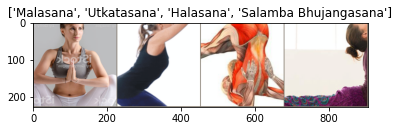

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)

from torchsummary import summary
#summary(model_ft.cuda(), input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
print('Before',model_ft.fc)
model_ft.fc = nn.Linear(num_ftrs, 29)
print('After',model_ft.fc)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

512
Before Linear(in_features=512, out_features=1000, bias=True)
After Linear(in_features=512, out_features=29, bias=True)


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.2560 Acc: 0.1024
val Loss: 1.8716 Acc: 0.4728

Epoch 1/24
----------
train Loss: 2.3816 Acc: 0.3131
val Loss: 1.2085 Acc: 0.6633

Epoch 2/24
----------
train Loss: 1.9878 Acc: 0.4258
val Loss: 0.9055 Acc: 0.7143

Epoch 3/24
----------
train Loss: 1.8329 Acc: 0.4778
val Loss: 0.7489 Acc: 0.7721

Epoch 4/24
----------
train Loss: 1.7473 Acc: 0.4957
val Loss: 0.8294 Acc: 0.7585

Epoch 5/24
----------
train Loss: 1.6251 Acc: 0.5316
val Loss: 0.8584 Acc: 0.7313

Epoch 6/24
----------
train Loss: 1.5362 Acc: 0.5580
val Loss: 0.6838 Acc: 0.7721

Epoch 7/24
----------
train Loss: 1.3013 Acc: 0.6408
val Loss: 0.5154 Acc: 0.8401

Epoch 8/24
----------
train Loss: 1.1433 Acc: 0.6911
val Loss: 0.4987 Acc: 0.8537

Epoch 9/24
----------
train Loss: 1.1141 Acc: 0.6911
val Loss: 0.5110 Acc: 0.8537

Epoch 10/24
----------
train Loss: 1.1431 Acc: 0.6826
val Loss: 0.4823 Acc: 0.8707

Epoch 11/24
----------
train Loss: 1.0606 Acc: 0.7039
val Loss: 0.4732 Acc: 0.8844

Ep

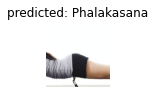

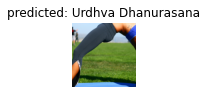

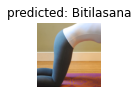

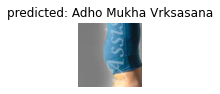

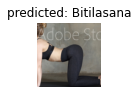

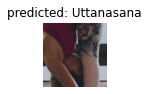

In [ ]:
visualize_model(model_ft)

In [ ]:
data_transforms = {
    'Test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = '/content/drive/MyDrive/yoga_pose/'#test_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Test']}
class_names = image_datasets['Test'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
correct = 0
total = 0

for data in dataloaders['Test']:
    images, labels = data
    final_model = model_ft.to(device)
    images = images.to(device)
    labels = labels.to(device)
    outputs = final_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print("Model accuracy on test data: ",  correct / total)

Model accuracy on test data:  0.6266666666666667
